In [1]:
import sys
sys.path.append("../")
from inference.ahoy import AHOYv5

ahoy = AHOYv5(model_path="../weights/ahoy-IR.engine")

⚙️ Loading TensorRT inference engine ../weights/ahoy-IR.engine
⚙️ TensorRT engine loaded successfully.
 - 📥 Input images: shape (2, 3, 640, 640), dtype float16
 - 📤 Output output0: shape (2, 25200, 14), dtype float16
 - 📤 Output output1: shape (2, 500), dtype float16
 - 📤 Output output2: shape (2, 500), dtype float16
⏳ Warming up...


  7.1 ms [avg] - preprocess
  4.3 ms [avg] - inference
  3.2 ms [avg] - postprocess
{'bboxes': array([[247.75 , 164.75 , 254.75 , 169.   ],
       [488.   , 172.625, 493.   , 177.875],
       [354.25 , 153.75 , 362.75 , 167.   ]]),
 'scores': array([0.56396484, 0.55810547, 0.72802734]),
 'classes': array([3., 3., 2.]),
 'hor_points': array([[  0.        , 138.65078901, 512.        , 161.31942338]]),
 'hor_score': array([0.29816931])}


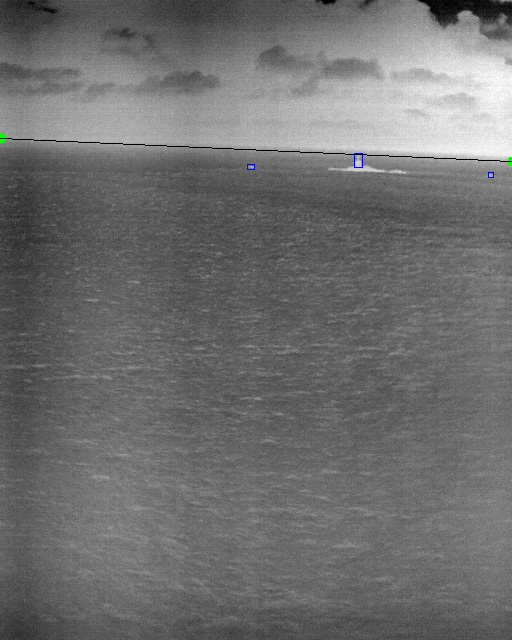

In [2]:
from pprint import pprint
from urllib.request import urlopen
import numpy as np
from PIL import Image
from utils.horizon import draw_horizon, draw_bboxes

url = "https://github.com/SEA-AI/.github/blob/main/assets/example_1_IR.jpg?raw=true"
image = np.array(Image.open(urlopen(url)).convert('RGB'))
image = np.stack([image for _ in range(ahoy.model.input_bs)], axis=0)

ahoy(image, conf_thresh=0.147, iou_thresh=0.1)  # warmup
n = 100
for i in range(n):
    preds = ahoy(image, conf_thresh=0.147, iou_thresh=0.1)[0]

# print average times
for name, profile in ahoy.profiles.items():
    print(f"{profile.t / n * 1E3:>5.1f} ms [avg] - {name}")

bboxes = preds[:, :4] # x1, y1, x2, y2
scores = preds[:, 4] # scores (probabilities)
classes = preds[:, 5] # indices of classes
hor_points, hor_score = bboxes[classes == -1], scores[classes == -1]
bboxes, scores, classes = bboxes[classes != -1], scores[classes != -1], classes[classes != -1]
pprint({
    "bboxes": bboxes,
    "scores": scores,
    "classes": classes,
    "hor_points": hor_points,
    "hor_score": hor_score
}, sort_dicts=False)

I = image[0]
dets = np.hstack((bboxes, scores[:, np.newaxis], classes[:, np.newaxis]))
I = draw_bboxes(I, dets, color=(0, 0, 255), thickness=1)
I = draw_horizon(I, keypoints=hor_points.reshape(-1, 2), color=(0, 0, 0), diameter=1)
I = Image.fromarray(I)
I  # .reduce(2) if I.width >= 1024 else I

In [3]:
batch_preds = ahoy.detect(image, output_mode="qa")
for i, sample_preds in enumerate(batch_preds):
    print(f"Sample {i}:")
    for bbox, label, cls, score in sample_preds:
        print(f"{bbox=}, {label=}, {cls=}, {score=}")

Sample 0:
bbox=array([0.48388672, 0.25742188, 0.49755859, 0.2640625 ]), label='FAR_AWAY_OBJECT', cls=3, score=0.56396484375
bbox=array([0.953125  , 0.26972656, 0.96289062, 0.27792969]), label='FAR_AWAY_OBJECT', cls=3, score=0.55810546875
bbox=array([0.69189453, 0.24023438, 0.70849609, 0.2609375 ]), label='BUOY', cls=2, score=0.72802734375
bbox=array([0.        , 0.21542722, 1.        , 0.25314421]), label='HORIZON', cls=-1, score=0.260009765625
Sample 1:
bbox=array([0.48388672, 0.25742188, 0.49755859, 0.2640625 ]), label='FAR_AWAY_OBJECT', cls=3, score=0.56396484375
bbox=array([0.953125  , 0.26972656, 0.96289062, 0.27792969]), label='FAR_AWAY_OBJECT', cls=3, score=0.55810546875
bbox=array([0.69189453, 0.24023438, 0.70849609, 0.2609375 ]), label='BUOY', cls=2, score=0.72802734375
bbox=array([0.        , 0.21542722, 1.        , 0.25314421]), label='HORIZON', cls=-1, score=0.260009765625


In [4]:
ahoy.detect(image, output_mode="tf")

[{'detection_boxes': array([[0.25742188, 0.48388672, 0.2640625 , 0.49755859],
         [0.26972656, 0.953125  , 0.27792969, 0.96289062],
         [0.24023438, 0.69189453, 0.2609375 , 0.70849609],
         [0.21542722, 0.        , 0.25314421, 1.        ]]),
  'detection_scores': array([0.56396484, 0.55810547, 0.72802734, 0.26000977]),
  'detection_classes': array([ 3.,  3.,  2., -1.]),
  'num_detections': 4},
 {'detection_boxes': array([[0.25742188, 0.48388672, 0.2640625 , 0.49755859],
         [0.26972656, 0.953125  , 0.27792969, 0.96289062],
         [0.24023438, 0.69189453, 0.2609375 , 0.70849609],
         [0.21542722, 0.        , 0.25314421, 1.        ]]),
  'detection_scores': array([0.56396484, 0.55810547, 0.72802734, 0.26000977]),
  'detection_classes': array([ 3.,  3.,  2., -1.]),
  'num_detections': 4}]